# Loading Libraries

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

Using TensorFlow backend.


# Loading CIFAR-10 Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Getting Number of classes and defining class labels

In [4]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Reshaping and Normalizing data

Convert class vectors to binary class matrices:

In [5]:
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

Normalizing the data into the range between -1 and 1, because Generator is using tanh as activation function:

In [6]:
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

# Define Model

## Generator

Define Generator Function: Here we define generator network which is composed of 5 layers. First layer is a fully connected. Then we use 3 transposed convolution layers, and all these layers use LeakyRelu as activation function and also use Batch Normalization. The last layer is a transposed convolution layer but it uses tanh as its activation function.

In [23]:
def build_generator(latent_dim, init):
  generator = Sequential()

  # FC: 
  generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
  generator.add(Reshape((2, 2, 512)))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 1: 
  generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 2: 
  generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 3: 
  generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  # Conv 4: 
  generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                                activation='tanh'))
  return generator

Defining inputs of build_generator function:

In [10]:
# latent space dimension
latent_dim = 100
init = initializers.RandomNormal(stddev=0.02)

Call build_generator function:

In [11]:
generator = build_generator(latent_dim, init)

Visualization of Generator model:

In [12]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)        

## Discriminator

Define Discriminator function: Here we define discriminator network which is composed of 4 convolution layers and and one fully connected layer after them and a Dense layer as output layer. All convolution layers use LeakyRelu as activation function and also use Batch Normalization. Fully connected layer is a Flatten layer and output layer is a Dense layer and uses sigmoid as activation function.

In [24]:
def build_discriminator():

  img_shape = X_train[0].shape

  discriminator = Sequential()

  # Conv 1:
  discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                          input_shape=(img_shape), kernel_initializer=init))
  discriminator.add(LeakyReLU(0.2))

  # Conv 2:
  discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  # Conv 3: 
  discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  # Conv 4: 
  discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  # FC
  discriminator.add(Flatten())

  # Output
  discriminator.add(Dense(1, activation='sigmoid'))

  return discriminator

Call build_discriminator function:

In [15]:
discriminator = build_discriminator()

Visualization of Discriminator model:

In [16]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)        

# Compile model


## Compile Discriminator Model

In [18]:
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

## Defining Combined network of Generator and Discriminator nets

First we give noise z as input of generator and generate image. Then we give the image generated by generator to the Discriminator and it makes a decision about the image. In fact the Discriminator gives us the probability that this image is fake or real. Then we define a combined model called d_g and give the noise z and the decision which is the Discriminator output to this combined network

In [19]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

## Compiling combined network (DCGAN)

In [20]:
d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])


## DCGAN model vizualization

In [21]:
d_g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


# Fit model

First we seperate input data to batches with size of 32. Then we start training. For each epoch, we loop over all data batches and for each batch we do the followings:
1. We get the batch(real samples) called X and consider real*(1 - smooth) as y vector(target), then give these data to the discriminator and train it on this data and compute discriminator loss for real data
2. We generate noise z which is a 100 dimension vector with random normal data, and give this data to generator and generate a fake data. Then we consider fake vector which is all zero as y(target). Then we train discriminator with this fake data and the fake target which is zero vector called fake and compute the discriminator loss for fake data
3. Then we compute the discriminator loss which is the average of discriminator loss for fake and real data
4. Finally we give the noise z as x and real vector which is all one vector as y to d_g network and train it on this data and compute generator loss
5. After training network on all batches in each epoch, we generate a 100 dimensional noise z and give this data to generator and it generates 10*10 samples

epoch = 1/50, d_loss=0.264, g_loss=3.619                                                                                                     


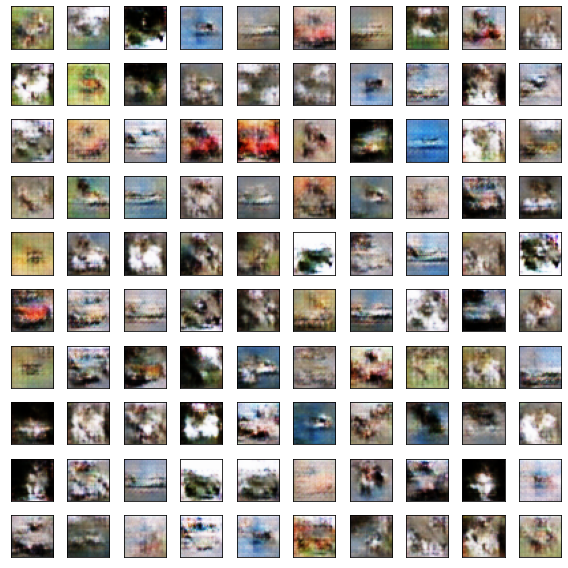

epoch = 2/50, d_loss=0.243, g_loss=1.583                                                                                                     
epoch = 3/50, d_loss=0.402, g_loss=3.404                                                                                                     
epoch = 4/50, d_loss=0.210, g_loss=3.888                                                                                                     
epoch = 5/50, d_loss=0.453, g_loss=3.322                                                                                                     
epoch = 6/50, d_loss=0.597, g_loss=5.401                                                                                                     
epoch = 7/50, d_loss=0.215, g_loss=3.512                                                                                                     
epoch = 8/50, d_loss=0.330, g_loss=1.793                                                                                                     
epoch 

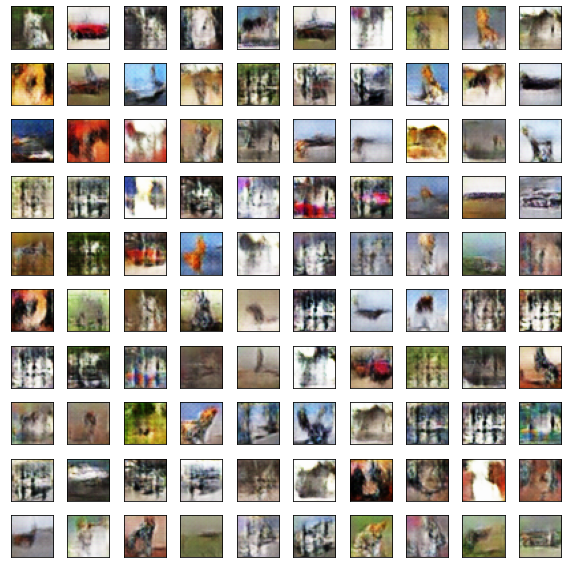

epoch = 12/50, d_loss=0.374, g_loss=3.217                                                                                                     
epoch = 13/50, d_loss=0.237, g_loss=4.784                                                                                                     
epoch = 14/50, d_loss=0.215, g_loss=3.690                                                                                                     
epoch = 15/50, d_loss=0.388, g_loss=3.204                                                                                                     
epoch = 16/50, d_loss=0.223, g_loss=4.560                                                                                                     
epoch = 17/50, d_loss=0.349, g_loss=3.111                                                                                                     
epoch = 18/50, d_loss=0.208, g_loss=4.870                                                                                                     

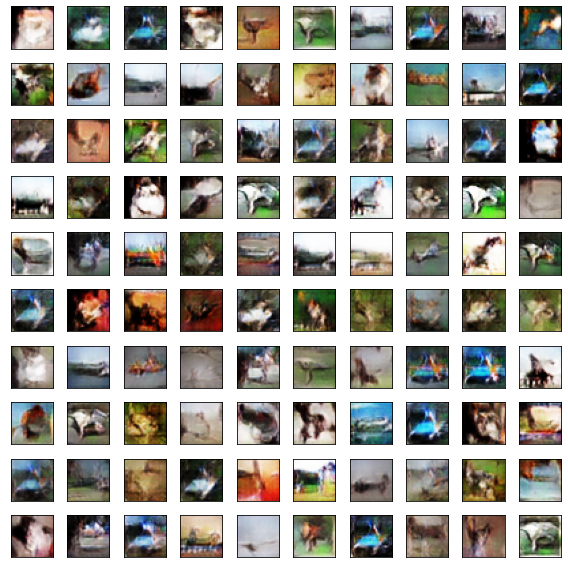

epoch = 22/50, d_loss=0.265, g_loss=3.197                                                                                                     
epoch = 23/50, d_loss=0.181, g_loss=7.672                                                                                                     
epoch = 24/50, d_loss=0.201, g_loss=4.722                                                                                                     
epoch = 25/50, d_loss=0.221, g_loss=5.663                                                                                                     
epoch = 26/50, d_loss=0.176, g_loss=7.565                                                                                                     
epoch = 27/50, d_loss=0.241, g_loss=4.146                                                                                                     
epoch = 28/50, d_loss=0.200, g_loss=5.224                                                                                                     

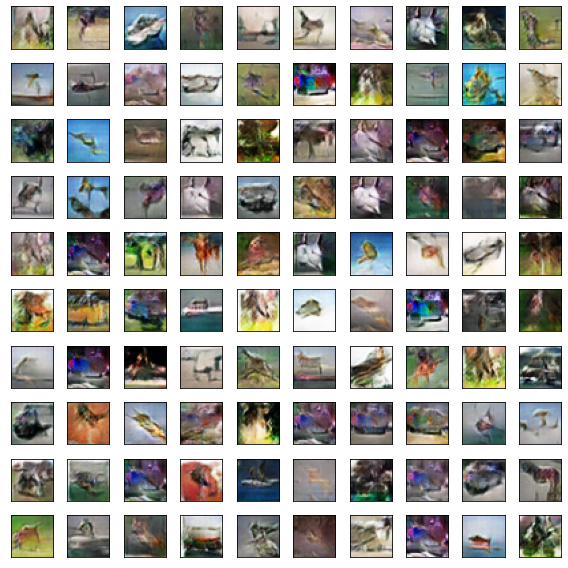

epoch = 32/50, d_loss=0.218, g_loss=4.669                                                                                                     
epoch = 33/50, d_loss=0.175, g_loss=6.367                                                                                                     
epoch = 34/50, d_loss=0.186, g_loss=4.833                                                                                                     
epoch = 35/50, d_loss=0.222, g_loss=5.415                                                                                                     
epoch = 36/50, d_loss=0.222, g_loss=4.270                                                                                                     
epoch = 37/50, d_loss=0.409, g_loss=3.819                                                                                                     
epoch = 38/50, d_loss=0.187, g_loss=7.315                                                                                                     

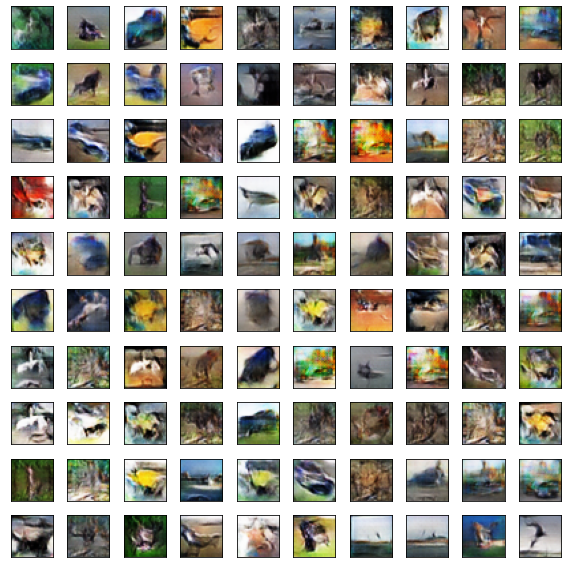

epoch = 42/50, d_loss=0.200, g_loss=3.539                                                                                                     
epoch = 43/50, d_loss=0.188, g_loss=5.360                                                                                                     
epoch = 44/50, d_loss=0.208, g_loss=3.798                                                                                                     
epoch = 45/50, d_loss=0.243, g_loss=5.662                                                                                                     
epoch = 46/50, d_loss=0.233, g_loss=4.376                                                                                                     
epoch = 47/50, d_loss=0.205, g_loss=4.489                                                                                                     
epoch = 48/50, d_loss=0.172, g_loss=7.057                                                                                                     

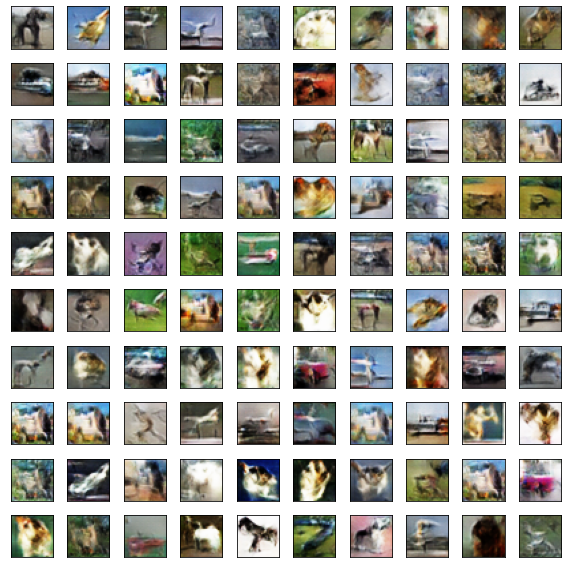

In [ ]:
epochs = 50
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 100
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        plt.figure(figsize = (8,8))
        gs1 = gridspec.GridSpec(4, 4)
        # set the spacing between axes. 
        for k in range(samples):
            gs1.update(wspace=0.0025, hspace=0.0005) 
            plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

# Evaluate model

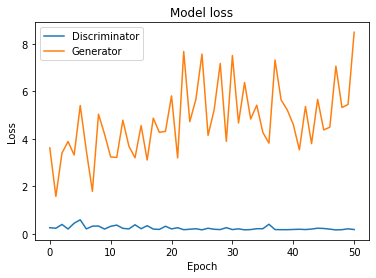

In [ ]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='upper left')
plt.show()